# Optimizadores

## SGD

Hasta ahora cada vez que hemos entrenado una red hemos usado como optimizador `torch.optim.SGD`, es decir, el descenso del gradiente estocástico (stochastic gradient descent SGD). Pero cuando vimos la teoría de cómo funciona una red neuronal solo hablamos del descenso del gradiente. Vamos a ver en qué se diferencian ambos

Como hemos visto, dividimos el dataset de datos en batches para meterle a la red el mayor número de datos a la vez. Y hemos visto que cuanto mayor es el tamaño de cada batch mejor, la red obtiene mejores resultados. En un caso ideal, lo mejor es meterle a la red todos los datos del dataset, pero esto normalmente no es posible, por eso se divide en batches, porque normalmente hay muchos más datos que capacidad tiene la GPU

Vamos a ver la diferencia de entrenar una red metiendo todos los datos en la memoria de la GPU, metiendo batches y metiendo cada vez solo un dato

Vamos a verlo con el ejemplo del dataset Cancer

In [1]:
from sklearn import datasets
import pandas as pd

cancer = datasets.load_breast_cancer()
cancer_df = pd.DataFrame(cancer['data'], columns=cancer['feature_names'])
cancer_df['type'] = cancer['target']
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,type
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


Creamos un dataset

In [2]:
import torch

class CancerDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe):
        cols = [col for col in dataframe.columns if col != 'target']
        self.parameters = torch.from_numpy(dataframe[cols].values).type(torch.float32)
        self.targets = torch.from_numpy(dataframe['type'].values).type(torch.float32)
        self.targets = self.targets.reshape((len(self.targets), 1))

    def __len__(self):
        return len(self.parameters)

    def __getitem__(self, idx):
        parameters = self.parameters[idx]
        target = self.targets[idx]
        return parameters, target

ds = CancerDataset(cancer_df)
train_ds, valid_ds = torch.utils.data.random_split(ds, [int(0.8*len(ds)), len(ds) - int(0.8*len(ds))], generator=torch.Generator().manual_seed(42))

Creamos la arquitectura de la red neuronal y vemos si tenemos disponible la GPU

In [3]:
from torch import nn

class CancerNeuralNetwork(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_layers=[100, 50, 20]):
        super().__init__()
        self.network = torch.nn.Sequential(
            torch.nn.Linear(num_inputs, hidden_layers[0]),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_layers[0], hidden_layers[1]),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_layers[1], hidden_layers[2]),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_layers[2], num_outputs),
        )
        self.activation = torch.nn.Sigmoid()

    def forward(self, x):
        logits = self.network(x)
        probs = self.activation(logits)
        return logits, probs

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


Creamos una función de entrenamiento donde ya estén incluidas las épocas. Esta función nos devolverá dos listas, una con las pérdidas y otra con la iteracción

In [4]:
def train_loop(dataloader, model, loss_fn, optimizer, epochs, num_prints=4):
    size = len(dataloader.dataset)
    model.train()

    losses = []
    iteration = []
    iter = 0

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        for batch, (X, y) in enumerate(dataloader):
            # X and y to device
            X, y = X.to(device), y.to(device)

            # Compute prediction and loss
            logits, probs = model(X)
            loss = loss_fn(probs, y)

            # Add to lists
            losses.append(loss.item())
            iteration.append(iter)
            iter += 1

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch % (int(len(dataloader)/num_prints)+1) == 0:
                loss, current = loss.item(), batch * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    print("Done!")

    return losses, iteration

Creamos el dataloader con todo el dataset, instanciamos la red, la entrenamos y mostramos la evolución de la función de pérdida

Epoch 1
-------------------------------
loss: 1.056493  [    0/  455]
Epoch 2
-------------------------------
loss: 3.218772  [    0/  455]
Epoch 3
-------------------------------
loss: 18.689789  [    0/  455]
Epoch 4
-------------------------------
loss: 2.206232  [    0/  455]
Epoch 5
-------------------------------
loss: 5.156389  [    0/  455]
Epoch 6
-------------------------------
loss: 0.986477  [    0/  455]
Epoch 7
-------------------------------
loss: 2.165606  [    0/  455]
Epoch 8
-------------------------------
loss: 3.208040  [    0/  455]
Epoch 9
-------------------------------
loss: 2.576705  [    0/  455]
Epoch 10
-------------------------------
loss: 1.265881  [    0/  455]
Epoch 11
-------------------------------
loss: 2.289510  [    0/  455]
Epoch 12
-------------------------------
loss: 1.036823  [    0/  455]
Epoch 13
-------------------------------
loss: 1.599657  [    0/  455]
Epoch 14
-------------------------------
loss: 0.992616  [    0/  455]
Epoch 15
-----

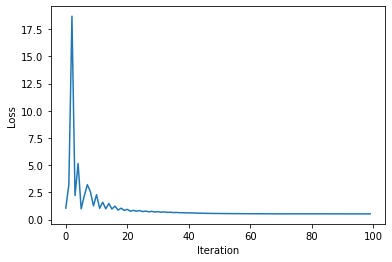

In [5]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

BS_train = len(train_ds)
train_dl = DataLoader(train_ds, batch_size=BS_train, shuffle=True)

# Se define una semilla para que la inicialización de los pesos aleatoria sea siempre la misma
seed = 27
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
model = CancerNeuralNetwork(num_inputs=31, num_outputs=1).to(device)

LR = 1e-3
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)

losses_all, iteractions_all = train_loop(train_dl, model, loss_fn, optimizer, epochs=100)

# Plot loss vs. iteration
plt.plot(iteractions_all, losses_all)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

Lo hacemos ahora para un dataset con un solo dato en cada batch

Epoch 1
-------------------------------
loss: 0.582549  [    0/  455]
loss: 0.493020  [  114/  455]
loss: 0.534528  [  228/  455]
loss: 0.882166  [  342/  455]
Epoch 2
-------------------------------
loss: 0.766721  [    0/  455]
loss: 0.399518  [  114/  455]
loss: 0.438514  [  228/  455]
loss: 0.459391  [  342/  455]
Epoch 3
-------------------------------
loss: 0.288174  [    0/  455]
loss: 0.362757  [  114/  455]
loss: 0.515966  [  228/  455]
loss: 0.002224  [  342/  455]
Epoch 4
-------------------------------
loss: 0.325709  [    0/  455]
loss: 0.693598  [  114/  455]
loss: 0.348110  [  228/  455]
loss: 0.239611  [  342/  455]
Epoch 5
-------------------------------
loss: 0.403256  [    0/  455]
loss: 0.762577  [  114/  455]
loss: 0.019120  [  228/  455]
loss: 0.009778  [  342/  455]
Epoch 6
-------------------------------
loss: 0.021781  [    0/  455]
loss: 0.000293  [  114/  455]
loss: 0.398638  [  228/  455]
loss: 0.407082  [  342/  455]
Epoch 7
-------------------------------


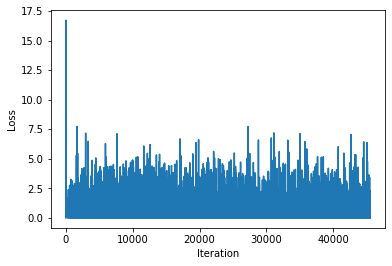

In [6]:
BS_train = 1
train_dl = DataLoader(train_ds, batch_size=BS_train, shuffle=True)

# Se define una semilla para que la inicialización de los pesos aleatoria sea siempre la misma
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
model = CancerNeuralNetwork(num_inputs=31, num_outputs=1).to(device)

LR = 1e-3
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)

losses_one, iteractions_one = train_loop(train_dl, model, loss_fn, optimizer, epochs=100)

# Plot loss vs. iteration
plt.plot(iteractions_one, losses_one)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

Y por último con un dataset de un batch size de 64

Epoch 1
-------------------------------
loss: 1.059702  [    0/  455]
loss: 4.506156  [  192/  455]
loss: 4.726321  [  384/  455]
Epoch 2
-------------------------------
loss: 1.139742  [    0/  455]
loss: 0.990593  [  192/  455]
loss: 0.668562  [  384/  455]
Epoch 3
-------------------------------
loss: 0.852827  [    0/  455]
loss: 1.153293  [  192/  455]
loss: 0.608410  [  384/  455]
Epoch 4
-------------------------------
loss: 0.618310  [    0/  455]
loss: 0.860146  [  192/  455]
loss: 1.075192  [  384/  455]
Epoch 5
-------------------------------
loss: 0.690239  [    0/  455]
loss: 0.890696  [  192/  455]
loss: 0.583555  [  384/  455]
Epoch 6
-------------------------------
loss: 0.798250  [    0/  455]
loss: 0.702855  [  192/  455]
loss: 0.574865  [  384/  455]
Epoch 7
-------------------------------
loss: 0.743511  [    0/  455]
loss: 0.608566  [  192/  455]
loss: 0.539146  [  384/  455]
Epoch 8
-------------------------------
loss: 0.625906  [    0/  455]
loss: 0.508446  [  1

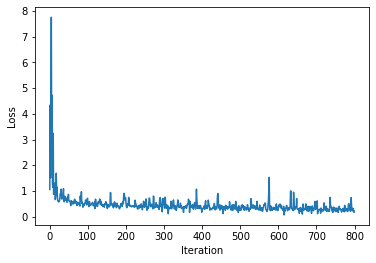

In [7]:
BS_train = 64
train_dl = DataLoader(train_ds, batch_size=BS_train, shuffle=True)

# Se define una semilla para que la inicialización de los pesos aleatoria sea siempre la misma
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
model = CancerNeuralNetwork(num_inputs=31, num_outputs=1).to(device)

LR = 1e-3
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)

losses_mid, iteractions_mid = train_loop(train_dl, model, loss_fn, optimizer, epochs=100)

# Plot loss vs. iteration
plt.plot(iteractions_mid, losses_mid)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

Representamos los 3 juntos para ver la diferencia

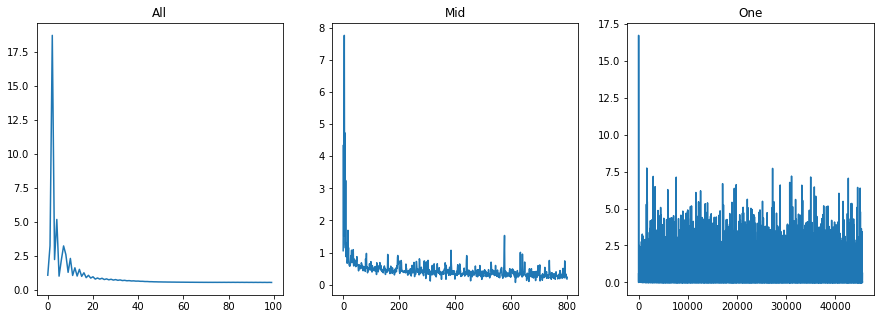

In [8]:
# Subplot with three panels of losses and iterations
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(iteractions_all, losses_all)
axs[0].set_title("All")
axs[1].plot(iteractions_mid, losses_mid)
axs[1].set_title("Mid")
axs[2].plot(iteractions_one, losses_one)
axs[2].set_title("One")
plt.show()

Como se puede ver la función de coste es muy estable cuando se utilizan todos los datos en cada época (all), tiene un poco más de ruido cuando se utiliza un batch size con algunos datos (mid) y tiene mucho ruido cuando en cada iteracción se le mete solo un dato (one)

Esto es debido a que cuando se le meten varios datos a la red, se calcula la función de coste de todos esos datos, se caculan los gradientes y se modifican los parámetros en función de esos gradientes.

Cuando se le meten todos los datos a la red, el cálculo del error se va a hacer para todos, por lo que la actualización de los parámetros se va a hacer de la mejor manera para todos los datos de la red y por eso el entrenamiento es tan estable. Pero a medida que se van disminuyendo la cantidad de datos que se introduce, el cálculo del error se hace para esos datos, por lo que la actualización de los parámetros se hace de la mejor manera para los datos introducidos.

Pero puede darse el caso que entren datos que hagan que haya mucho error, por lo que el gradiente va a ser muy grande, y por tanto haya una gran corrección de los parámetros, más incluso de lo que debería. En la siguiente iteracción pueden entrar otro conjunto de datos que hacen que la anterior corrección no haya sido la mejor posible, por lo que otra vez el error va a ser grande, los gradientes también y la corrección de los parámetros otra vez también sea grande.

Por lo que con cuantos menos datos entrenemos a la red en cada iteracción, habrá más ruido en la evolución de la función de pérdida, hasta llegar al peor caso, en el que si solo se le mete un dato, el error tenga tanta pérdida que ni se pueda llegar a un buen punto de entrenamiento

Es por esto, por lo que cuantos más datos metamos en cada iteracción, es decir, cuanto más grande sea el batch size, mejor será el entrenamiento. Pero la realidad es que casi siempre vamos a tener tantos datos que no van a entrar todos en la memoria de la GPU, por lo que casi siempre vamos a tener que dividir el conjunto de datos en batches

Cuando en cada iteracción se le entrena a la red con todos los datos es cuando de verdad podemos decir que estamos haciendo el descenso por el gradiente. Pero cuando lo que hacemos es meter subconjuntos se dice que se hace un descenso del gradiente estocástico.

Estocástico quiere decir que está sometido al azar y que es objeto de análisis estadístico. Y es lo que está pasando, estamos metiendo subconjuntos de datos, pero no sabemos si son los mejores para entrenar o no, y en cada iteracción el subconjunto va a ser distinto, por lo que la evolución del error no va a ser siempre la misma

Es por eso, por lo que hemos usado el optimizador SGD, porque usando este abarcamos todos los casos, si usamos todo el conjunto de datos de entrenamiento en cada iteracción el SGD pasa a ser un descenso del gradiente (sin ser estocástico), pero si metemos un subconjunto de 1 o más datos, sin llegar a meter todos estamos en el caso del descenso del gradiente estocástico

## SGD, momentum, RMSprop y Adam

Ahora que ya sabemos la diferencia entre el ``SGD`` y el ``GD``, y sabemos que siempre usamos el ``SGD`` vamos a ver los otros tipos de optimizadores más comunes que se pueden usar.

Hay más optimizadores de los que vamos a ver, pero los que vamos a ver son los más comunes, los que mejor suelen funcionar y los que se suelen usar siempre, en especial ``Adam``

Para ver la diferencia entre los tres vamos a verlo con el primer ejemplo de neurona que vimos. En ese ejemplo teníamos una distribución de puntos e intentamos ajustar el problema con una sola neurona con un solo parámetro.

In [1]:
import numpy as np

x = np.array( [ 0.        ,  0.34482759,  0.68965517,  1.03448276,  1.37931034,
        1.72413793,  2.06896552,  2.4137931 ,  2.75862069,  3.10344828,
        3.44827586,  3.79310345,  4.13793103,  4.48275862,  4.82758621,
        5.17241379,  5.51724138,  5.86206897,  6.20689655,  6.55172414,
        6.89655172,  7.24137931,  7.5862069 ,  7.93103448,  8.27586207,
        8.62068966,  8.96551724,  9.31034483,  9.65517241, 10.        ])

y = np.array( [-0.16281253,  1.88707606,  0.39649312,  0.03857752,  4.0148778 ,
        0.58866234,  3.35711859,  1.94314906,  6.96106424,  5.89792585,
        8.47226615,  3.67698542, 12.05958678,  9.85234481,  9.82181679,
        6.07652248, 14.17536744, 12.67825433, 12.97499286, 11.76098542,
       12.7843083 , 16.42241036, 13.67913705, 15.55066478, 17.45979602,
       16.41982806, 17.01977617, 20.28151197, 19.38148414, 19.41029831])

Representamos la distribución de puntos

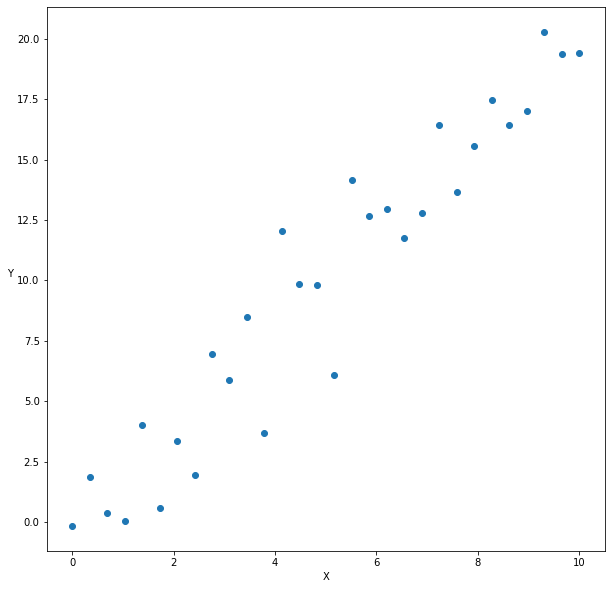

In [2]:
import matplotlib.pyplot as plt

# 3D plot of the data
fig = plt.figure(figsize=(10,10))
plt.scatter(x, y)
plt.xlabel('X')
plt.ylabel('Y  ', rotation=0)
plt.show()

Creamos el modelo, inicializamos el parámetro al azahar y vemos como se comporta

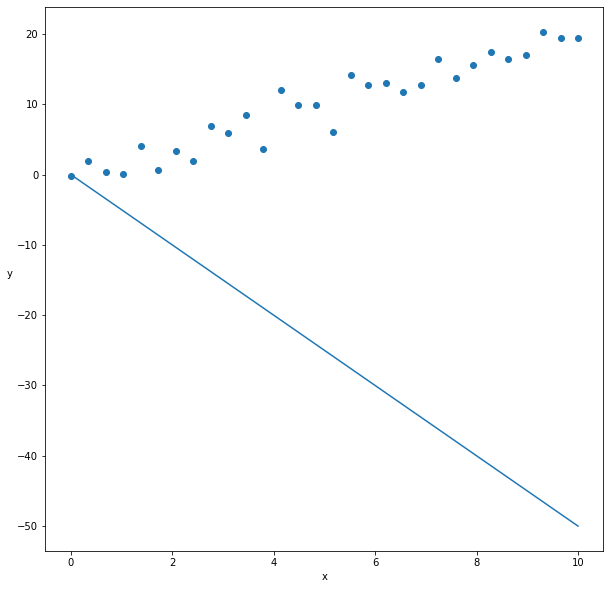

In [3]:
def model(x, w1):
    return w1*x

w1 = -5
output = model(x, w1)

fig = plt.figure(figsize=(10,10))
plt.scatter(x, y)
plt.plot(x, output)
plt.xlabel('x')
plt.ylabel('y  ', rotation=0)
plt.show()

Vemos que nuestro modelo de momento no se asemeja a la distribución de puntos, tenemos que entrenar la neurona. Vemos el ``MSE`` que tenemos

In [4]:
def loss(x, y, w1):
    return ((y-model(x, w1))**2).mean()
    
error = loss(x, y, w1)
error

1660.8830450910689

Representamos el error en función del valor del parámetro $\omega_1$

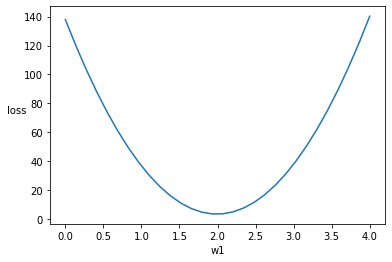

In [5]:
posibles_a = np.linspace(0, 4, 30)
perdidas = np.empty_like(posibles_a)

for i in range (30):
    perdidas[i] = loss(x, y, posibles_a[i])

plt.plot(posibles_a, perdidas)
plt.xlabel('w1')
plt.ylabel('loss  ', rotation=0)
plt.show()

### SGD

Entrenamos la neurona con el optimizador que hemos visto hasta ahora, el ``SGD``, que como ya hemos visto, calcula el gradiente y corrige el valor del parámetro $\omega_1$ de la neurona

In [6]:
def gradiente_w1(x, y, output):
    return -2*(((y-output)*x).mean())

Se entrena con un valor de learning rate no óptimo, que va a hacer que el modelo tarde mucho en llegar a la solución, pero que nos va a servir para ver la mejora de usar los otros optimizadores. Además se entrena hasta que el error sea menor que un valor, no un número de épocas determinado

In [83]:
lr = 2.93e-2
w1_0 = -5

w1 = w1_0
error = loss(x, y, w1_0)

Ws1 = []
LOSSES = []
Zs = []
print(f"w1: {w1:.2f}, error: {error:.2f}")
i = 0
MAX_ERROR = 3.5
while (error > MAX_ERROR):
    output = model(x, w1)
    dl_w1 = gradiente_w1(x, y, output)
    w1 = w1 - lr*dl_w1
    z = model(x, w1)
    error = loss(x, y, w1)

    Ws1.append(w1)
    LOSSES.append(error)
    Zs.append(z)

    if i % 50 == 0:
        print(f"Step {i}, w1: {w1:.2f}, error: {error:.2f}")
    i += 1

print(f"Final: Step {i}, w1: {w1:.2f}, error: {error:.2f}")


w1: -5.00, error: 1660.88
Step 0, w1: 8.89, error: 1618.11
Step 50, w1: 5.58, error: 440.28
Step 100, w1: 3.86, error: 121.64
Step 150, w1: 2.96, error: 35.43
Step 200, w1: 2.50, error: 12.11
Step 250, w1: 2.25, error: 5.80
Step 300, w1: 2.13, error: 4.10
Step 350, w1: 2.06, error: 3.63
Step 400, w1: 2.03, error: 3.51
Final: Step 410, w1: 1.96, error: 3.50


In [84]:
epochs_sdg = i+1
print(f"Se han necesitado {epochs_sdg} iteraciones para llegar a la solución")

Se han necesitado 411 iteraciones para llegar a la solución


Se representa cómo ha sido la evolución

w1_min: -6.82, w1_max: 10.89
(410,)


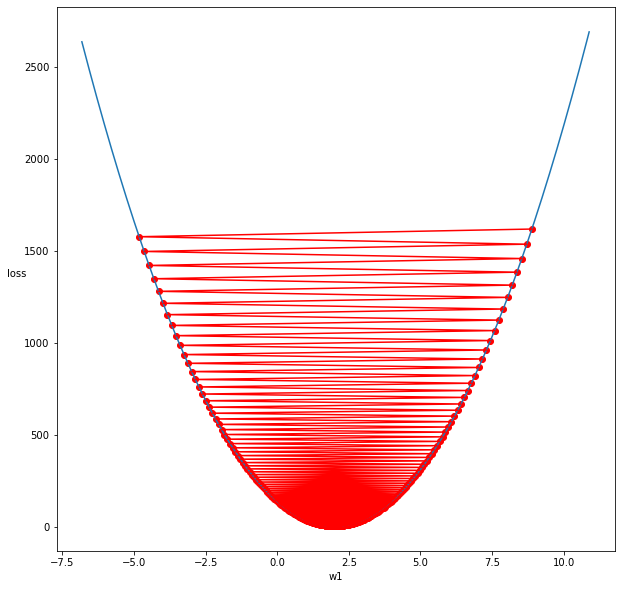

In [85]:
# Se crea la figura
fig = plt.figure(figsize=(10,10))

# Se crean los datos para representar
N = len(Ws1)
window = 2
w1_min = min(Ws1)-window
w1_max = max(Ws1)+window
print(f"w1_min: {w1_min:.2f}, w1_max: {w1_max:.2f}")
posibles_w1 = np.linspace(w1_min, w1_max, N)
perdidas = np.empty_like(posibles_w1)
print(posibles_w1.shape)

for i in range (N):
    perdidas[i] = loss(x, y, posibles_w1[i])

plt.plot(posibles_w1, perdidas)
plt.xlabel('w1')
plt.ylabel('loss  ', rotation=0)
plt.scatter(Ws1, LOSSES, c='r')
plt.plot(Ws1, LOSSES, c='r')
plt.show()

In [68]:
# Creamos GIF con la evolución del entrenamiento

from matplotlib.animation import FuncAnimation

# Creamos la gráfica inicial
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_tight_layout(True)
ax1.set_xlabel('X')
ax1.set_ylabel('Y  ', rotation=0)
ax1.set_ylim(-40, 90)
ax2.set_xlabel('w1')
ax2.set_ylabel('loss     ', rotation=0)

# Se dibujan los datos que persistiran en toda la evolución de la gráfica
ax1.scatter(x, y)
ax2.plot(posibles_w1, perdidas, linewidth = 3)

# Se dibuja el resto de lineas que irán cambiando durante el entrenamiento
line1, = ax1.plot(x, Zs[0], 'k', linewidth=2)                             # Recta generada con la pendiente a aprendida
line2, = ax2.plot(Ws1[0:2], LOSSES[0:2], 'orange', linewidth=2)                # Recta entre dos losses
punto2, = ax2.plot(Ws1[0], LOSSES[0], 'r*')                               # Punto donde se calcula el gradiente

# Se dibujan textos dentro de la segunda figura del subplot
fontsize = 12
a_text = ax2.text(-4, 2000, f'a = {Ws1[0]:.2f}', fontsize = fontsize)
error_text = ax2.text(-4, 1500, f'loss = {LOSSES[0]:.2f}', fontsize = fontsize)

# Se dibuja un título
titulo = fig.suptitle(f'step: {0}', fontsize=fontsize)

# Se define la función que va a modificar la gráfica con la evolución del entrenamiento
def update(i):
    label = f'step {i}'

    # Se actualiza la linea 1. Recta generada con la pendiente a aprendida
    line1.set_ydata(Zs[i])

    # Se actualiza la linea 2. Recta entre dos losses
    line2.set_xdata(Ws1[i-1:i+1])
    line2.set_ydata(LOSSES[i-1:i+1])

    # Se actualiza el punto 2. Punto donde se calcula el gradiente
    punto2.set_xdata(Ws1[i])
    punto2.set_ydata(LOSSES[i])

    # Se actualizan los textos
    a_text.set_text(f'a = {Ws1[i]:.2f}')
    error_text.set_text(f'loss = {LOSSES[i]:.2f}')
    titulo.set_text(f'step: {i}')

    return line1, ax1, punto2, ax2, a_text, error_text

# Se crea la animación con un refresco cada 200 ms
interval = 200 # ms
anim = FuncAnimation(fig, update, frames=np.arange(0, epochs_sdg-1), interval=interval)

# # Se guarda en un GIF
gif_name = "GIFs/entrenamiento_SGD.gif"
anim.save(gif_name, dpi=80, writer='imagemagick')
plt.close()

MovieWriter imagemagick unavailable; using Pillow instead.


Como se había dicho, se ha elegido un learning rate que hace que la solución no sea óptima, y como se puede ver, hasta que llega a la mejor solución oscila mucho. Pero esto nos va a servir para ver como al usar los otros optimizadores se obtiene mejor solución

### Momentum

Supongamos que tenemos una función de coste como la de la siguiente imagen

![loss](Imagenes/loss.png)

Cada círculo corresponde a un nivel de error, es decir, en el borde el error es mayor que en el centro

Una posible iteracción con ``SGD`` podría ser la siguiente

![SGD](Imagenes/SGD.png)

Como se puede ver, la solución oscila mucho

Una manera ideal de solucionar esto es hacer que se avance en el eje vertical, pero no en el horizontal. Esto se puede conseguir añadiendo una media de las medidas anteriores.

Como ya vimos en el tema del learning rate finder, una manera de calcular una media es hacer uso de los [promedios ponderados exponencialmente](https://medium.com/@dhartidhami/exponentially-weighted-averages-5de212b5be46). Así la media de un dato se puede obtener mediante

$$\overline{M_i} = \left(1-\beta\right)M_i + \beta\overline{M_{i-1}}$$

De esta manera podemos obtener la media de los gradientes mediante

$$\overline{\frac{\partial{loss}}{\partial\theta}_i} = \left(1-\beta\right)\frac{\partial{loss}}{\partial\theta}_i + \beta\overline{\frac{\partial{loss}}{\partial\theta}_{i-1}}$$

El valor típoco que se suelen usar para $\beta$ es 0.9

Una vez se tiene la media del gradiente, se pueden actualizar los parámetros mediante

$$\theta = \theta - \alpha\overline{\frac{\partial{loss}}{\partial\theta}}$$

Es decir, no se actualiza el parámetro con el gradiente, sino con la media del gradiente. Vamos a ver gráficamente qué ocurre

![momentum](GIFs/SGDmomentum.gif)

 1. Vemos que tenemos el gradiente de la primera iteracción, este gradiente se puede descoponer en su componente horizontal y vertical (lineas verdes)
 2. A continuación aparece la linea azul del gradiente de la segunda iteracción. Este gradiente también se puede descomponer en sus componentes horizontal y vertical (lineas amarillas)
 3. A estos componentes horizontal t vertical del gradiente de la segunda iteracción (lineas amarillas) se les sumarían los componentes del gradiente de la iteracción anterior (lineas verdes). Como resultado, quedan como componetes horizontal y vertical las lineas naranjas
 4. Ya no se usa el gradiente de la segunda iteracción, sino el resultado de la suma de las componetens horizontal y vertical de la primera y segunda iteracción
 5. Ya no se muestran las componentes horizontal y vertical de las siguientes iteracciones, sino el resultado de usar momentum

Como en las primeras iteracciones no hay datos anteriores para hacer media, se puede hacer una corrección mediante la siguiente fórmula

$$\overline{\frac{\partial{loss}}{\partial\theta}_i} = \frac{\overline{\frac{\partial{loss}}{\partial\theta}_i}}{1-\beta · i^2}$$

Vamos a reentrenar el ejemplo anterior, con el mismo valor inicial de $\omega_1$ y el mismo valor de $\alpha$

In [58]:
def momentum(old_momentum, gradient, beta=0.9, iteracction=None):
    momentum = beta*old_momentum + (1-beta)*gradient
    if iteracction is not None:
        momentum = momentum / (1-beta**iteracction)
    return momentum

In [86]:
# lr = 1.49e-2
# w1_0 = -5

w1 = w1_0
error = loss(x, y, w1_0)

Ws1_momentum = []
LOSSES_momentum = []
Zs_momentum = []

old_momentum_w1 = 0

print(f"w1: {w1:.2f}, error: {error:.2f}")
i = 0
MAX_ERROR = 3.5
while (error > MAX_ERROR):
    output = model(x, w1)
    dl_w1 = gradiente_w1(x, y, output)
    momentum_w1 = momentum(old_momentum_w1, dl_w1)
    w1 = w1 - lr*momentum_w1
    z = model(x, w1)
    error = loss(x, y, w1)

    Ws1_momentum.append(w1)
    LOSSES_momentum.append(error)
    Zs_momentum.append(z)

    if i % 50 == 0:
        print(f"Step {i}, w1: {w1:.2f}, error: {error:.2f}")
        
    old_momentum_w1 = momentum_w1
    i += 1

print(f"Final: Step {i}, w1: {w1:.2f}, error: {error:.2f}")

w1: -5.00, error: 1660.88
Step 0, w1: -3.61, error: 1067.66
Step 50, w1: 2.02, error: 3.49
Final: Step 51, w1: 2.02, error: 3.49


In [87]:
epochs_momentum = i+1
print(f"Se han necesitado {epochs_momentum} iteraciones para llegar a la solución")

Se han necesitado 52 iteraciones para llegar a la solución


w1_min: -6.82, w1_max: 10.89
(410,)


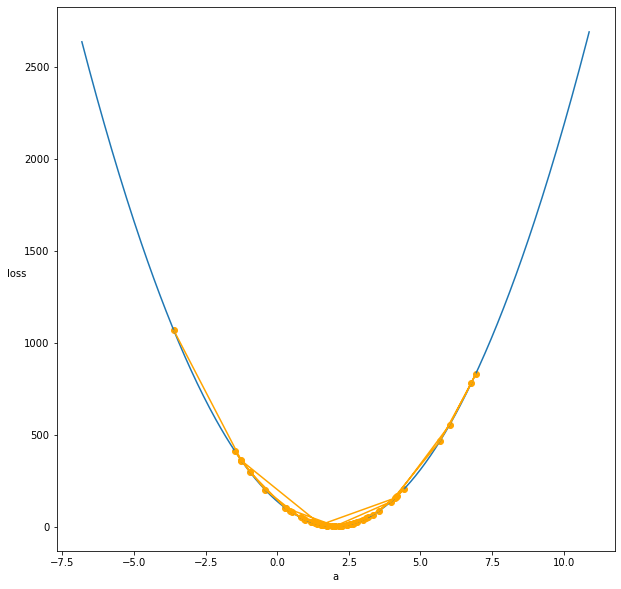

In [61]:
# Se crea la figura
fig = plt.figure(figsize=(10,10))

# Se crean los datos para representar
N = len(Ws1)
window = 2
w1_min = min(Ws1)-window
w1_max = max(Ws1)+window
print(f"w1_min: {w1_min:.2f}, w1_max: {w1_max:.2f}")
posibles_w1 = np.linspace(w1_min, w1_max, N)
perdidas = np.empty_like(posibles_w1)
print(posibles_w1.shape)

for i in range (N):
    perdidas[i] = loss(x, y, posibles_w1[i])

plt.plot(posibles_w1, perdidas)
plt.xlabel('a')
plt.ylabel('loss  ', rotation=0)
plt.scatter(Ws1_momentum, LOSSES_momentum, c='orange')
plt.plot(Ws1_momentum, LOSSES_momentum, c='orange')
plt.show()

In [67]:
# Creamos GIF con la evolución del entrenamiento

from matplotlib.animation import FuncAnimation

# Creamos la gráfica inicial
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_tight_layout(True)
ax1.set_xlabel('X')
ax1.set_ylabel('Y  ', rotation=0)
ax1.set_ylim(-40, 90)
ax2.set_xlabel('w1')
ax2.set_ylabel('loss     ', rotation=0)

# Se dibujan los datos que persistiran en toda la evolución de la gráfica
ax1.scatter(x, y)
ax2.plot(posibles_w1, perdidas, linewidth = 3)

# Se dibuja el resto de lineas que irán cambiando durante el entrenamiento
line1, = ax1.plot(x, Zs_momentum[0], 'k', linewidth=2)                             # Recta generada con la pendiente a aprendida
line2, = ax2.plot(Ws1_momentum[0:2], LOSSES_momentum[0:2], 'orange', linewidth=2)                # Recta entre dos losses
punto2, = ax2.plot(Ws1_momentum[0], LOSSES_momentum[0], 'r*')                               # Punto donde se calcula el gradiente

# Se dibujan textos dentro de la segunda figura del subplot
fontsize = 12
a_text = ax2.text(-4, 2000, f'a = {Ws1_momentum[0]:.2f}', fontsize = fontsize)
error_text = ax2.text(-4, 1500, f'loss = {LOSSES_momentum[0]:.2f}', fontsize = fontsize)

# Se dibuja un título
titulo = fig.suptitle(f'step: {0}', fontsize=fontsize)

# Se define la función que va a modificar la gráfica con la evolución del entrenamiento
def update(i):
    label = f'step {i}'

    # Se actualiza la linea 1. Recta generada con la pendiente a aprendida
    line1.set_ydata(Zs_momentum[i])

    # Se actualiza la linea 2. Recta entre dos losses
    line2.set_xdata(Ws1_momentum[i-1:i+1])
    line2.set_ydata(LOSSES_momentum[i-1:i+1])

    # Se actualiza el punto 2. Punto donde se calcula el gradiente
    punto2.set_xdata(Ws1_momentum[i])
    punto2.set_ydata(LOSSES_momentum[i])

    # Se actualizan los textos
    a_text.set_text(f'a = {Ws1_momentum[i]:.2f}')
    error_text.set_text(f'loss = {LOSSES_momentum[i]:.2f}')
    titulo.set_text(f'step: {i}')

    return line1, ax1, punto2, ax2, a_text, error_text

# Se crea la animación con un refresco cada 200 ms
interval = 200 # ms
# anim = FuncAnimation(fig, update, frames=np.arange(0, 10), interval=interval)
anim = FuncAnimation(fig, update, frames=np.arange(0, epochs-1), interval=interval)

# # Se guarda en un GIF
gif_name = "GIFs/entrenamiento_momentum.gif"
anim.save(gif_name, dpi=80, writer='imagemagick')
plt.close()

MovieWriter imagemagick unavailable; using Pillow instead.


Como se puede ver se han necesitado muchas menos iteracciones para llegar a una solución, y en la gráfica vemos como ya no hay tantas oscilaciones

In [69]:
def RMSprop(old_RMSprop, gradient, beta=0.999, iteracction=None):
    rmsprop = beta*old_RMSprop + (1-beta)*(gradient**2)
    if iteracction is not None:
        rmsprop = rmsprop / (1-beta**iteracction)
    return rmsprop

In [88]:
# lr = 1.49e-2
# w1_0 = -5

w1 = w1_0
error = loss(x, y, w1_0)

Ws1_rmsprop = []
LOSSES_rmsprop = []
Zs_rmsprop = []

old_rmsprop_w1 = 0
epsilon = 1e-8

print(f"w1: {w1:.2f}, error: {error:.2f}")
i = 0
MAX_ERROR = 3.5
while (error > MAX_ERROR):
    output = model(x, w1)
    dl_w1 = gradiente_w1(x, y, output)
    rmsprop_w1 = RMSprop(old_rmsprop_w1, dl_w1, beta=0.9999)#, iteracction=i+1)
    w1 = w1 - lr*dl_w1/((rmsprop_w1**0.5)+epsilon)
    z = model(x, w1)
    error = loss(x, y, w1)

    Ws1_rmsprop.append(w1)
    LOSSES_rmsprop.append(error)
    Zs_rmsprop.append(z)

    if i % 10 == 0:
        print(f"Step {i}, w1: {w1:.2f}, error: {error:.2f}, rmsprop: {rmsprop_w1:.2f}")
        
    old_rmsprop_w1 = rmsprop_w1
    i += 1

print(f"Final: Step {i}, w1: {w1:.2f}, error: {error:.2f}")

w1: -5.00, error: 1660.88
Step 0, w1: -2.07, error: 562.78, rmsprop: 22.48
Step 10, w1: 1.93, error: 3.61, rmsprop: 35.47
Final: Step 13, w1: 1.96, error: 3.49


In [89]:
epochs_rmsprop = i+1
print(f"Se han necesitado {epochs_rmsprop} iteraciones para llegar a la solución")

Se han necesitado 14 iteraciones para llegar a la solución


w1_min: -6.82, w1_max: 10.89
(410,)


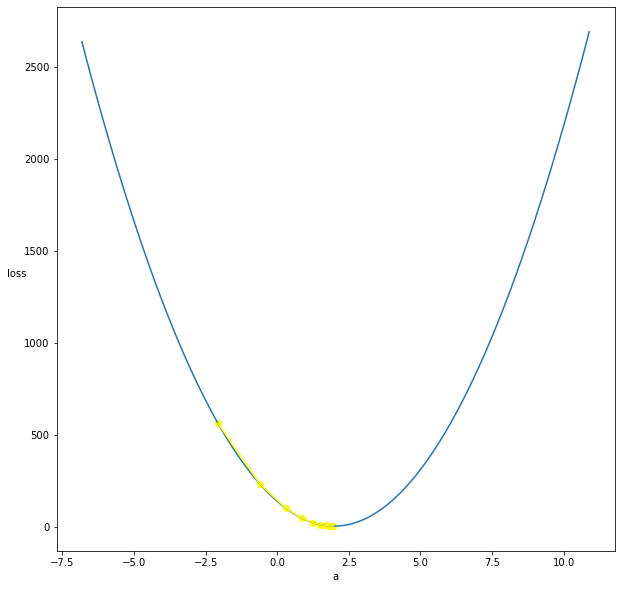

In [72]:
# Se crea la figura
fig = plt.figure(figsize=(10,10))

# Se crean los datos para representar
N = len(Ws1)
window = 2
w1_min = min(Ws1)-window
w1_max = max(Ws1)+window
print(f"w1_min: {w1_min:.2f}, w1_max: {w1_max:.2f}")
posibles_w1 = np.linspace(w1_min, w1_max, N)
perdidas = np.empty_like(posibles_w1)
print(posibles_w1.shape)

for i in range (N):
    perdidas[i] = loss(x, y, posibles_w1[i])

plt.plot(posibles_w1, perdidas)
plt.xlabel('a')
plt.ylabel('loss  ', rotation=0)
plt.scatter(Ws1_rmsprop, LOSSES_rmsprop, c='yellow')
plt.plot(Ws1_rmsprop, LOSSES_rmsprop, c='yellow')
plt.show()

In [73]:
# Creamos GIF con la evolución del entrenamiento

from matplotlib.animation import FuncAnimation

# Creamos la gráfica inicial
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_tight_layout(True)
ax1.set_xlabel('X')
ax1.set_ylabel('Y  ', rotation=0)
ax1.set_ylim(-40, 90)
ax2.set_xlabel('w1')
ax2.set_ylabel('loss     ', rotation=0)

# Se dibujan los datos que persistiran en toda la evolución de la gráfica
ax1.scatter(x, y)
ax2.plot(posibles_w1, perdidas, linewidth = 3)

# Se dibuja el resto de lineas que irán cambiando durante el entrenamiento
line1, = ax1.plot(x, Zs_rmsprop[0], 'k', linewidth=2)                             # Recta generada con la pendiente a aprendida
line2, = ax2.plot(Ws1_rmsprop[0:2], LOSSES_rmsprop[0:2], 'orange', linewidth=2)                # Recta entre dos losses
punto2, = ax2.plot(Ws1_rmsprop[0], LOSSES_rmsprop[0], 'r*')                               # Punto donde se calcula el gradiente

# Se dibujan textos dentro de la segunda figura del subplot
fontsize = 12
a_text = ax2.text(-4, 2000, f'a = {Ws1_rmsprop[0]:.2f}', fontsize = fontsize)
error_text = ax2.text(-4, 1500, f'loss = {LOSSES_rmsprop[0]:.2f}', fontsize = fontsize)

# Se dibuja un título
titulo = fig.suptitle(f'step: {0}', fontsize=fontsize)

# Se define la función que va a modificar la gráfica con la evolución del entrenamiento
def update(i):
    label = f'step {i}'

    # Se actualiza la linea 1. Recta generada con la pendiente a aprendida
    line1.set_ydata(Zs_rmsprop[i])

    # Se actualiza la linea 2. Recta entre dos losses
    line2.set_xdata(Ws1_rmsprop[i-1:i+1])
    line2.set_ydata(LOSSES_rmsprop[i-1:i+1])

    # Se actualiza el punto 2. Punto donde se calcula el gradiente
    punto2.set_xdata(Ws1_rmsprop[i])
    punto2.set_ydata(LOSSES_rmsprop[i])

    # Se actualizan los textos
    a_text.set_text(f'a = {Ws1_rmsprop[i]:.2f}')
    error_text.set_text(f'loss = {LOSSES_rmsprop[i]:.2f}')
    titulo.set_text(f'step: {i}')

    return line1, ax1, punto2, ax2, a_text, error_text

# Se crea la animación con un refresco cada 200 ms
interval = 200 # ms
# anim = FuncAnimation(fig, update, frames=np.arange(0, 10), interval=interval)
anim = FuncAnimation(fig, update, frames=np.arange(0, epochs-1), interval=interval)

# # Se guarda en un GIF
gif_name = "GIFs/entrenamiento_rmsprop.gif"
anim.save(gif_name, dpi=80, writer='imagemagick')
plt.close()

MovieWriter imagemagick unavailable; using Pillow instead.


In [74]:
def adam(old_momentum, old_rmsprop, gradient, beta1=0.9, beta2=0.999, iteracction=None):
    momentum = beta1*old_momentum + (1-beta1)*gradient
    rmsprop = beta2*old_rmsprop + (1-beta2)*(gradient**2)
    if iteracction is not None:
        momentum = momentum / (1-beta1**iteracction)
        rmsprop = rmsprop / (1-beta2**iteracction)
    return momentum, rmsprop

In [90]:
# lr = 1.49e-2
# w1_0 = -5

w1 = w1_0
error = loss(x, y, w1_0)

Ws1_adam = []
LOSSES_adam = []
Zs_adam = []

old_momentum_w1 = 0
old_rmsprop_w1 = 0

epsilon = 1e-8

print(f"w1: {w1:.2f}, error: {error:.2f}")
i = 0
MAX_ERROR = 3.5
while (error > MAX_ERROR):
    output = model(x, w1)
    dl_w1 = gradiente_w1(x, y, output)
    momentum_w1, rmsprop_w1 = adam(old_momentum_w1, old_rmsprop_w1, dl_w1, beta2=0.9999)#, iteracction=i+1)
    w1 = w1 - lr*momentum_w1/((rmsprop_w1**0.5)+epsilon)
    z = model(x, w1)
    error = loss(x, y, w1)

    Ws1_adam.append(w1)
    LOSSES_adam.append(error)
    Zs_adam.append(z)

    if i % 50 == 0:
        print(f"Step {i}, w1: {w1:.2f}, error: {error:.2f}")
        
    old_momentum_w1 = momentum_w1
    old_rmsprop_w1 = rmsprop_w1
    i += 1


print(f"Final: Step {i}, w1: {w1:.2f}, error: {error:.2f}")

w1: -5.00, error: 1660.88
Step 0, w1: -4.71, error: 1524.87
Final: Step 40, w1: 2.01, error: 3.48


In [91]:
epochs_adam = i+1
print(f"Se han necesitado {epochs_adam} iteraciones para llegar a la solución")

Se han necesitado 41 iteraciones para llegar a la solución


w1_min: -6.82, w1_max: 10.89
(410,)


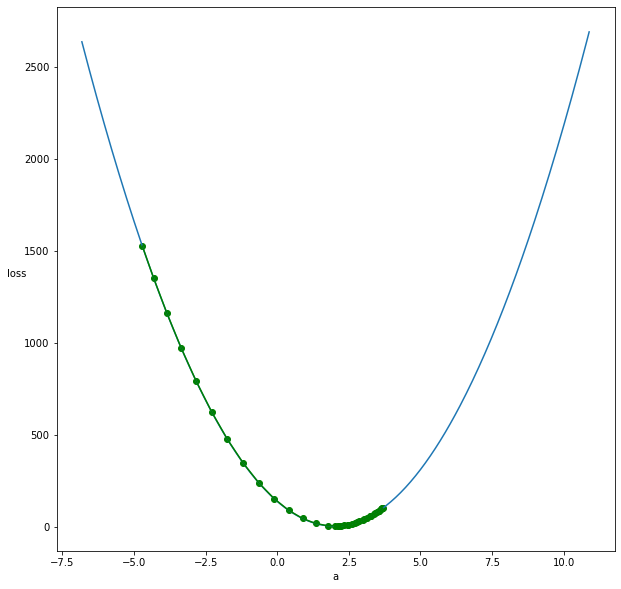

In [77]:
# Se crea la figura
fig = plt.figure(figsize=(10,10))

# Se crean los datos para representar
N = len(Ws1)
window = 2
w1_min = min(Ws1)-window
w1_max = max(Ws1)+window
print(f"w1_min: {w1_min:.2f}, w1_max: {w1_max:.2f}")
posibles_w1 = np.linspace(w1_min, w1_max, N)
perdidas = np.empty_like(posibles_w1)
print(posibles_w1.shape)

for i in range (N):
    perdidas[i] = loss(x, y, posibles_w1[i])

plt.plot(posibles_w1, perdidas)
plt.xlabel('a')
plt.ylabel('loss  ', rotation=0)
plt.scatter(Ws1_adam, LOSSES_adam, c='green')
plt.plot(Ws1_adam, LOSSES_adam, c='green')
plt.show()

In [82]:
# Creamos GIF con la evolución del entrenamiento

from matplotlib.animation import FuncAnimation

# Creamos la gráfica inicial
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_tight_layout(True)
ax1.set_xlabel('X')
ax1.set_ylabel('Y  ', rotation=0)
ax1.set_ylim(-40, 90)
ax2.set_xlabel('w1')
ax2.set_ylabel('loss     ', rotation=0)

# Se dibujan los datos que persistiran en toda la evolución de la gráfica
ax1.scatter(x, y)
ax2.plot(posibles_w1, perdidas, linewidth = 3)

# Se dibuja el resto de lineas que irán cambiando durante el entrenamiento
line1, = ax1.plot(x, Zs_adam[0], 'k', linewidth=2)                             # Recta generada con la pendiente a aprendida
line2, = ax2.plot(Ws1_adam[0:2], LOSSES_adam[0:2], 'orange', linewidth=2)                # Recta entre dos losses
punto2, = ax2.plot(Ws1_adam[0], LOSSES_adam[0], 'r*')                               # Punto donde se calcula el gradiente

# Se dibujan textos dentro de la segunda figura del subplot
fontsize = 12
a_text = ax2.text(-4, 2000, f'a = {Ws1_adam[0]:.2f}', fontsize = fontsize)
error_text = ax2.text(-4, 1500, f'loss = {LOSSES_adam[0]:.2f}', fontsize = fontsize)

# Se dibuja un título
titulo = fig.suptitle(f'step: {0}', fontsize=fontsize)

# Se define la función que va a modificar la gráfica con la evolución del entrenamiento
def update(i):
    label = f'step {i}'

    # Se actualiza la linea 1. Recta generada con la pendiente a aprendida
    line1.set_ydata(Zs_adam[i])

    # Se actualiza la linea 2. Recta entre dos losses
    line2.set_xdata(Ws1_adam[i-1:i+1])
    line2.set_ydata(LOSSES_adam[i-1:i+1])

    # Se actualiza el punto 2. Punto donde se calcula el gradiente
    punto2.set_xdata(Ws1_adam[i])
    punto2.set_ydata(LOSSES_adam[i])

    # Se actualizan los textos
    a_text.set_text(f'a = {Ws1_adam[i]:.2f}')
    error_text.set_text(f'loss = {LOSSES_adam[i]:.2f}')
    titulo.set_text(f'step: {i}')

    return line1, ax1, punto2, ax2, a_text, error_text

# Se crea la animación con un refresco cada 200 ms
interval = 200 # ms
anim = FuncAnimation(fig, update, frames=np.arange(0, epochs_adam-1), interval=interval)

# # Se guarda en un GIF
gif_name = "GIFs/entrenamiento_adam.gif"
anim.save(gif_name, dpi=80, writer='imagemagick')
plt.close()

MovieWriter imagemagick unavailable; using Pillow instead.


array([[<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

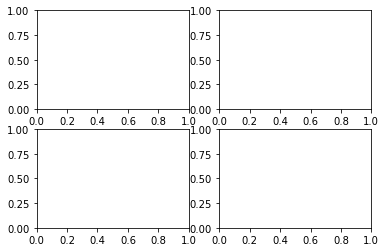

In [98]:
fig, ax = plt.subplots(2,2)
ax

<class 'matplotlib.lines.Line2D'>


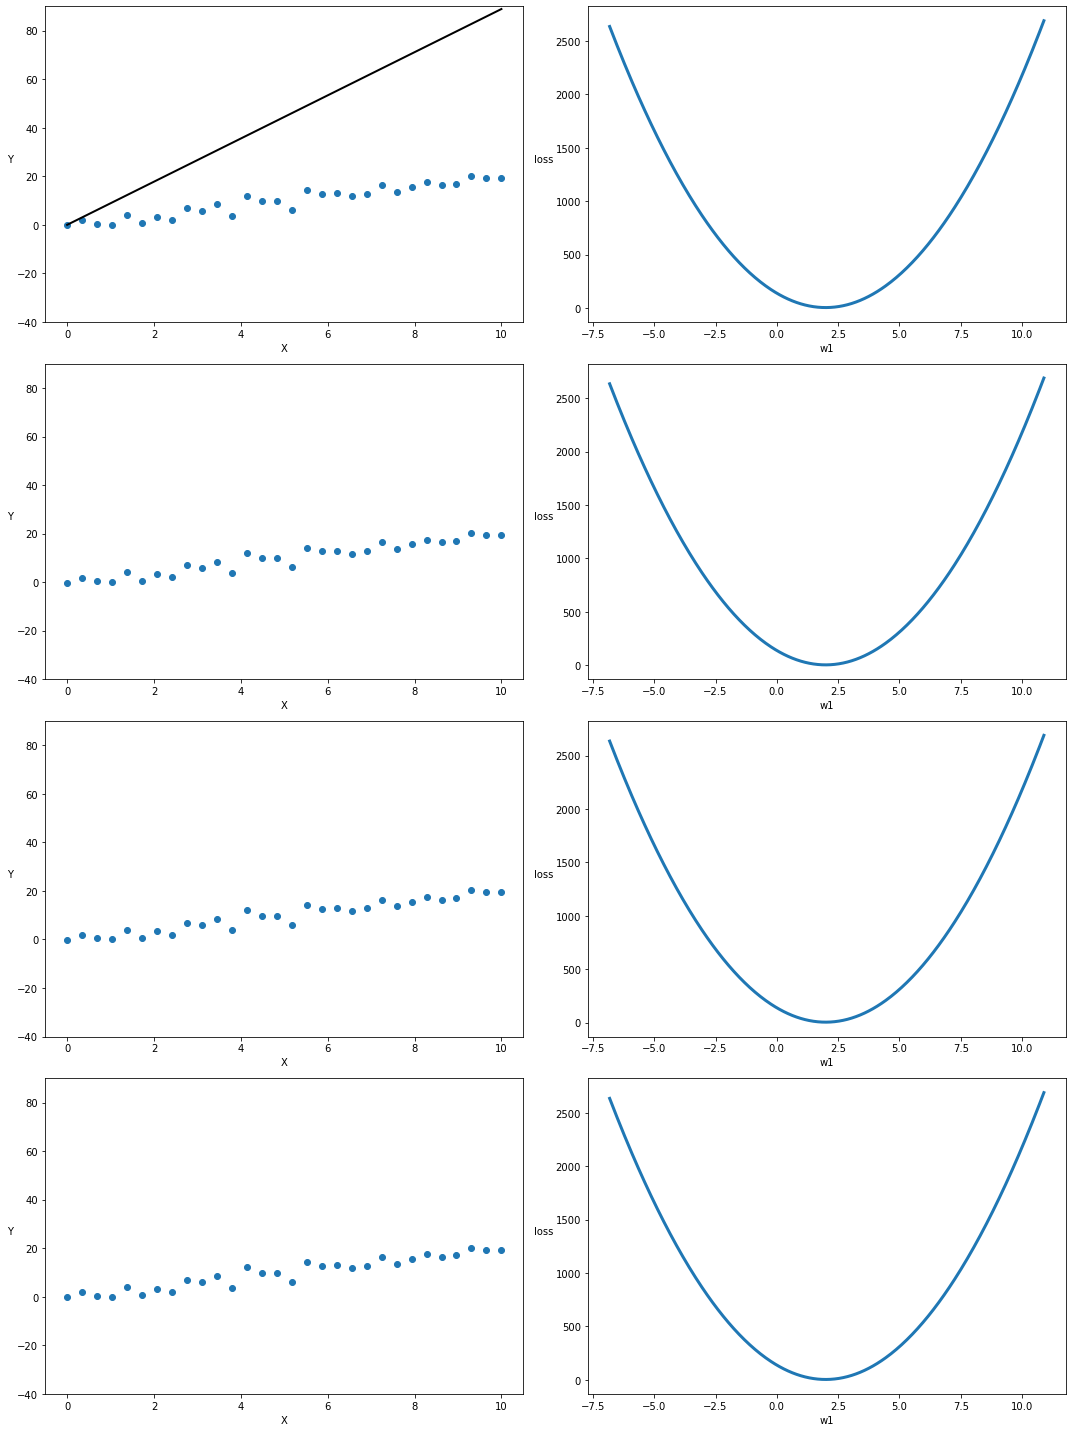

In [107]:
# Creamos GIF con la evolución del entrenamiento

from matplotlib.animation import FuncAnimation

# Creamos la gráfica inicial
fig, ax = plt.subplots(4,2, figsize=(15,20))
fig.set_tight_layout(True)
for i in range (4):
    ax[i,0].set_xlabel('X')
    ax[i,0].set_ylabel('Y  ', rotation=0)
    ax[i,0].set_ylim(-40, 90)
    ax[i,1].set_xlabel('w1')
    ax[i,1].set_ylabel('loss     ', rotation=0)

    # Se dibujan los datos que persistiran en toda la evolución de la gráfica
    ax[i,0].scatter(x, y)
    ax[i,1].plot(posibles_w1, perdidas, linewidth = 3)

# Se dibuja el resto de lineas que irán cambiando durante el entrenamiento
line11, = ax[0,0].plot(x, Zs[0], 'k', linewidth=2)
# line31, = ax3.plot(x, Zs_momentum[0], 'k', linewidth=2)
# line51, = ax5.plot(x, Zs_rmsprop[0], 'k', linewidth=2)
# line71, = ax7.plot(x, Zs_adam[0], 'k', linewidth=2)
# line12, = ax2.plot(Ws1[0:2], LOSSES[0:2], 'orange', linewidth=2)
# line32, = ax4.plot(Ws1_momentum[0:2], LOSSES_momentum[0:2], 'orange', linewidth=2)
# line52, = ax5.plot(Ws1_rmsprop[0:2], LOSSES_rmsprop[0:2], 'orange', linewidth=2)
# line72, = ax6.plot(Ws1_adam[0:2], LOSSES_adam[0:2], 'orange', linewidth=2)
# punto2, = ax2.plot(Ws1[0], LOSSES[0], 'r*')
# punto4, = ax4.plot(Ws1_momentum[0], LOSSES_momentum[0], 'r*')
# punto6, = ax6.plot(Ws1_rmsprop[0], LOSSES_rmsprop[0], 'r*')
# punto8, = ax8.plot(Ws1_adam[0], LOSSES_adam[0], 'r*')

# # Se dibujan textos dentro de la segunda figura del subplot
# fontsize = 12
# a_text = ax2.text(-4, 2000, f'a = {Ws1_adam[0]:.2f}', fontsize = fontsize)
# error_text = ax2.text(-4, 1500, f'loss = {LOSSES_adam[0]:.2f}', fontsize = fontsize)

# # Se dibuja un título
# titulo = fig.suptitle(f'step: {0}', fontsize=fontsize)

# Se define la función que va a modificar la gráfica con la evolución del entrenamiento
def update(i):
    label = f'step {i}'

    # Se actualiza la linea 1. Recta generada con la pendiente a aprendida
    line1.set_ydata(Zs_adam[i])

    # Se actualiza la linea 2. Recta entre dos losses
    line2.set_xdata(Ws1_adam[i-1:i+1])
    line2.set_ydata(LOSSES_adam[i-1:i+1])

    # Se actualiza el punto 2. Punto donde se calcula el gradiente
    punto2.set_xdata(Ws1_adam[i])
    punto2.set_ydata(LOSSES_adam[i])

    # Se actualizan los textos
    a_text.set_text(f'a = {Ws1_adam[i]:.2f}')
    error_text.set_text(f'loss = {LOSSES_adam[i]:.2f}')
    titulo.set_text(f'step: {i}')

    return line1, ax1, punto2, ax2, a_text, error_text

# Se crea la animación con un refresco cada 200 ms
# interval = 200 # ms
# anim = FuncAnimation(fig, update, frames=np.arange(0, epochs_adam-1), interval=interval)

# # # Se guarda en un GIF
# gif_name = "GIFs/entrenamiento_adam.gif"
# anim.save(gif_name, dpi=80, writer='imagemagick')
# plt.close()